In [36]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [37]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [38]:
import glob
import os
import rasterio

In [39]:
train_nir="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"
train_mask="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"

In [40]:
#Capture training image info as a list
train_nirs = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_nir):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_nirs.append(img)

In [41]:
#Capture training image info as a list
train_masks = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_mask):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_masks.append(img)

In [42]:

print(train_nirs)


[array([[106, 112, 120, ...,  28,  27,  28],
       [ 95, 105, 117, ...,  32,  30,  30],
       [121, 120, 111, ...,  30,  28,  26],
       ...,
       [155, 137, 167, ..., 146, 148, 140],
       [167, 147, 160, ..., 143, 137, 125],
       [202, 175, 158, ..., 126, 118, 111]], dtype=uint8), array([[ 26,  27,  29, ..., 125, 136, 127],
       [ 22,  24,  26, ..., 136, 138, 119],
       [ 25,  26,  27, ..., 124, 131, 118],
       ...,
       [104, 123, 123, ..., 104, 128, 108],
       [120, 126, 135, ..., 153, 150, 157],
       [133, 143, 129, ..., 153, 121, 145]], dtype=uint8), array([[126, 155, 114, ...,  56,  45,  60],
       [148, 119, 123, ...,  51,  60,  62],
       [119, 129, 113, ...,  87,  91,  88],
       ...,
       [164, 132, 124, ...,  76,  65,  68],
       [151, 123, 129, ...,  72,  63,  64],
       [149, 168, 134, ...,  49,  42,  40]], dtype=uint8), array([[ 58,  45,  53, ..., 133, 146, 141],
       [ 54,  79,  70, ..., 145, 159, 143],
       [ 70,  82,  98, ..., 126, 138, 

In [43]:
print(train_masks)

[array([[  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 

In [44]:
import cv2  # OpenCV for resizing

# Target shape for resizing
target_height, target_width = 256, 256

# Resize all arrays in train_masks to (500, 500)
resized_masks = [
    cv2.resize(mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST)
    for mask in train_masks
]

# Stack the resized arrays
train_masks_array = np.stack(resized_masks, axis=0)
print(f"Stacked array shape: {train_masks_array.shape}")


Stacked array shape: (920, 256, 256)


In [45]:
import numpy as np
import cv2  # OpenCV for resizing

def resize_or_pad_to_shape(arr, target_shape):
    # Handle 3D arrays (e.g., color images or multi-band arrays)
    if len(arr.shape) == 3:
        current_height, current_width, _ = arr.shape
    else:
        current_height, current_width = arr.shape
    
    target_height, target_width = target_shape

    if current_height > target_height or current_width > target_width:
        # Crop the array if it is larger than the target shape
        start_y = (current_height - target_height) // 2
        start_x = (current_width - target_width) // 2
        return arr[start_y:start_y + target_height, start_x:start_x + target_width]
    else:
        # Pad the array if it is smaller than the target shape
        pad_height = target_height - current_height
        pad_width = target_width - current_width
        pad_height_top = pad_height // 2
        pad_height_bottom = pad_height - pad_height_top
        pad_width_left = pad_width // 2
        pad_width_right = pad_width - pad_width_left
        return np.pad(arr, ((pad_height_top, pad_height_bottom), (pad_width_left, pad_width_right), (0, 0)), mode='constant', constant_values=0) if len(arr.shape) == 3 else np.pad(arr, ((pad_height_top, pad_height_bottom), (pad_width_left, pad_width_right)), mode='constant', constant_values=0)

# Assuming train_nirs is a list of numpy arrays
target_shape = (256, 256)

# Apply the function to all nirs (not masks)
padded_nirs = [resize_or_pad_to_shape(nir, target_shape) for nir in train_nirs]

# Stack the resized/padded arrays into a single array
train_nirs_array = np.stack(padded_nirs, axis=0)

# Verify the shape of the stacked array
print(f"Stacked array shape: {train_nirs_array.shape}")


Stacked array shape: (920, 256, 256)


In [46]:
train_masks_array = np.expand_dims(train_masks_array, axis=3)

In [47]:
print(train_masks_array.shape)

(920, 256, 256, 1)


In [48]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test1, y1, y_test = train_test_split(train_nirs_array, train_masks_array, test_size = 0.10, random_state = 0)

In [49]:
print("Class values in the dataset are ... ", np.unique(y1))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [  0 255]


In [50]:
################################################################
def multi_unet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

In [51]:
def get_model():
    return multi_unet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)

In [52]:
model = get_model()

In [53]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(X1, y1, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test1, y_test), 
                    #class_weight=class_weights,
                    shuffle=False)   

Epoch 1/20


c:\Users\Admin\anaconda3\envs\JintuEnv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_125']
Received: inputs=Tensor(shape=(None, 256, 256))
  warnings.warn(msg)


104/104 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3275 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 9/20
104/104 ━━━━━━━━

In [56]:
model.save("D:/Acres/January 2025/Assignment 8/Models/Unet/test.h5")

In [57]:
	# evaluate model
_, acc = model.evaluate(X_test1, y_test)
print("Accuracy is = ", (acc * 100.0), "%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9424 - loss: nan
Accuracy is =  94.2636251449585 %


In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
epochs = range(1, len(loss) + 1)

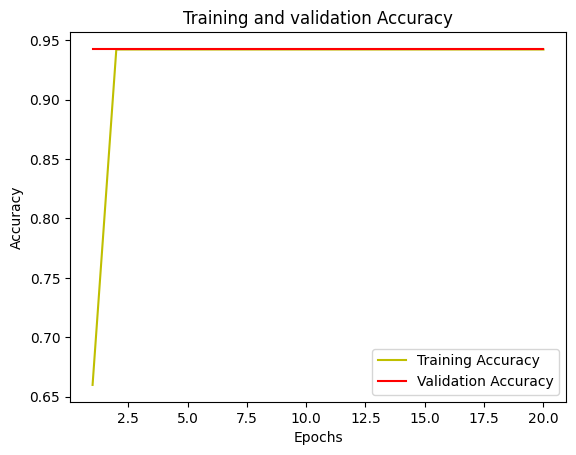

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

c:\Users\Admin\anaconda3\envs\JintuEnv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_125']
Received: inputs=Tensor(shape=(32, 256, 256))
  warnings.warn(msg)
c:\Users\Admin\anaconda3\envs\JintuEnv\Lib\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 256, 256, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


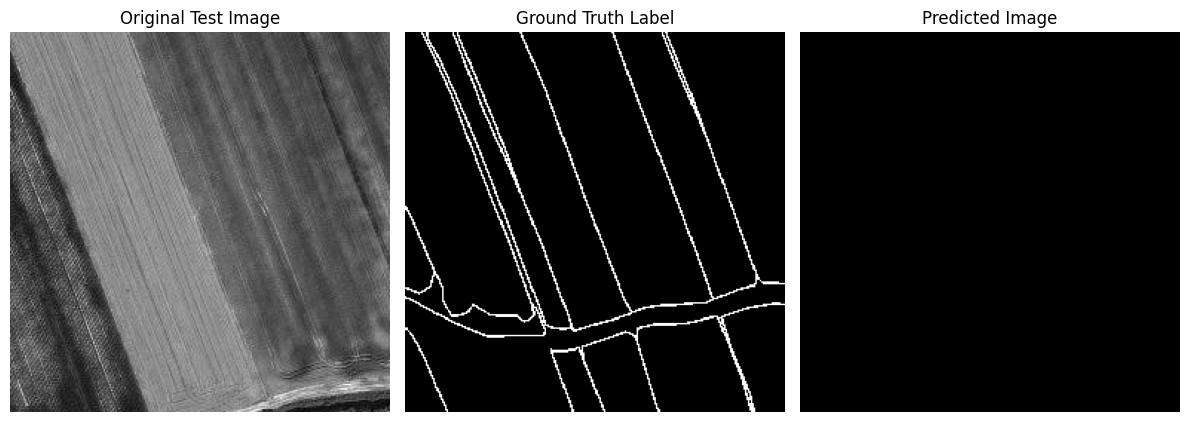

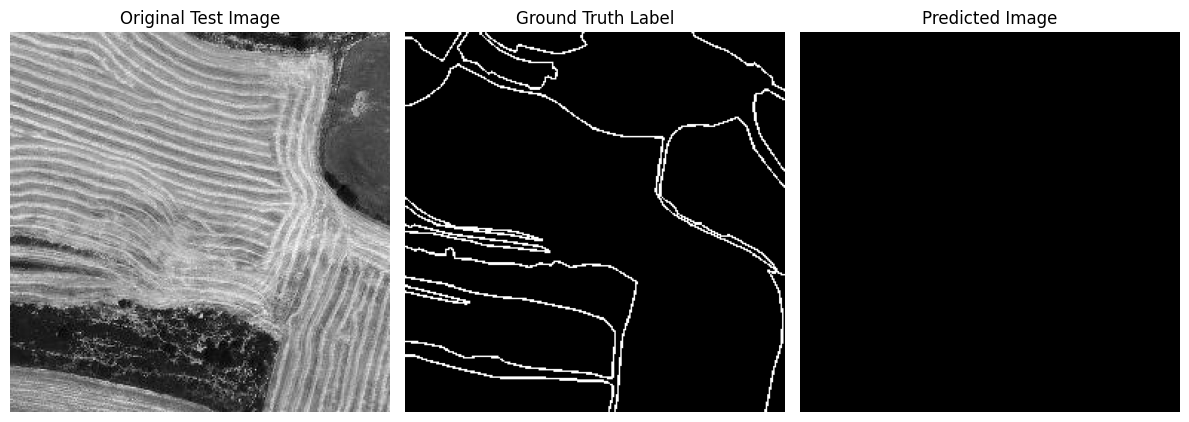

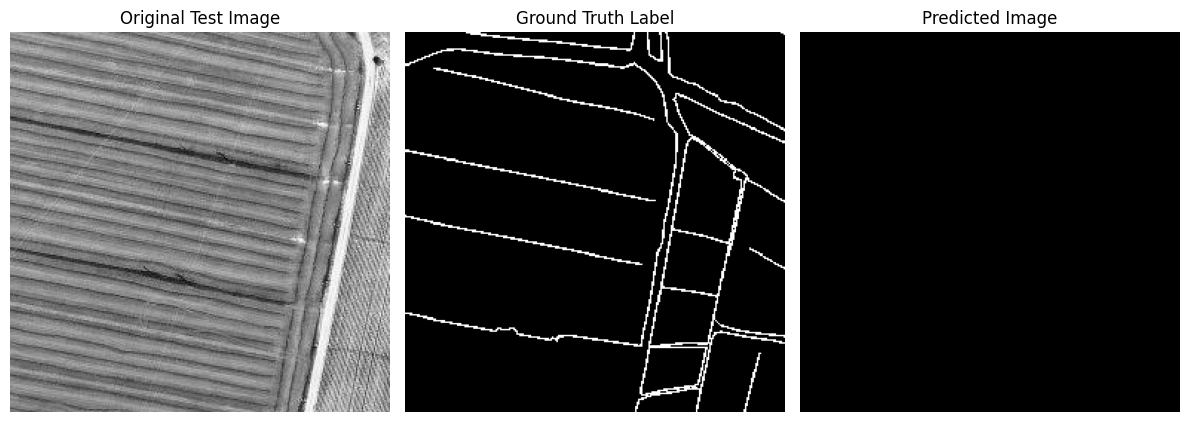

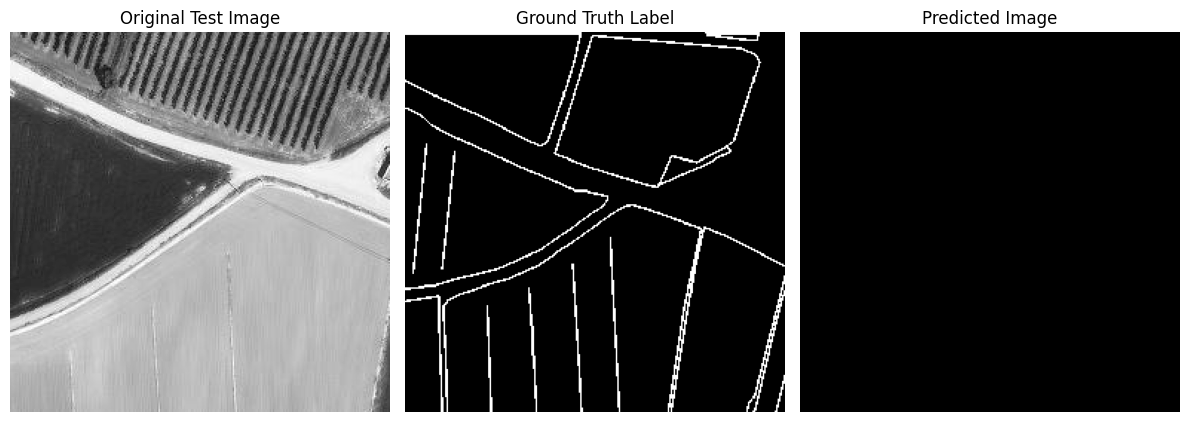

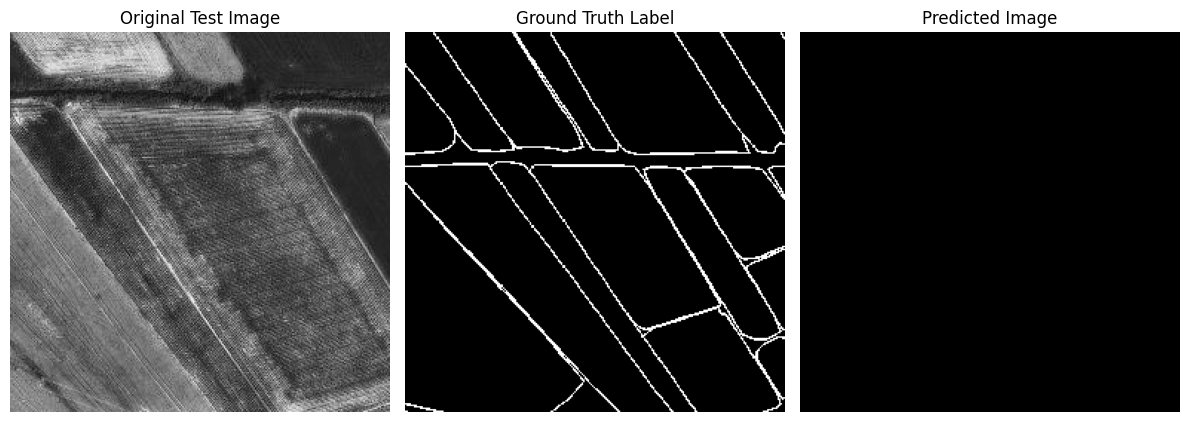

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize original test image, label, and predicted image
def visualize_results(test_images, test_labels, predictions, num_samples=5):
    """
    Visualizes a set of test images, ground truth labels, and predictions.

    Args:
        test_images (numpy.ndarray): Array of test images.
        test_labels (numpy.ndarray): Array of ground truth labels.
        predictions (numpy.ndarray): Array of predicted labels.
        num_samples (int): Number of samples to visualize.
    """
    for i in range(num_samples):
        plt.figure(figsize=(12, 8))

        # Show the original image
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[i], cmap="gray")
        plt.title("Original Test Image")
        plt.axis("off")

        # Show the ground truth label
        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[i], cmap="gray")
        plt.title("Ground Truth Label")
        plt.axis("off")

        # Show the predicted image
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap="gray")
        plt.title("Predicted Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Assuming the test data and model are already defined and loaded
# Predict on the test set
predictions = model.predict(X_test1)

# If the predictions are probabilities, convert them to binary labels
if predictions.shape[-1] > 1:  # If it's multi-class, take the argmax
    predictions = np.argmax(predictions, axis=-1)
else:  # For binary classification, threshold at 0.5
    predictions = (predictions > 0.5).astype(np.uint8)

# Ensure the dimensions match for visualization (remove unnecessary dimensions)
if len(predictions.shape) == 4 and predictions.shape[-1] == 1:
    predictions = predictions.squeeze(axis=-1)
if len(y_test.shape) == 4 and y_test.shape[-1] == 1:
    y_test = y_test.squeeze(axis=-1)

# Visualize the results
visualize_results(X_test1, y_test, predictions, num_samples=5)
